# Atlas Obscura Doc2Vec model

In [18]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import namedtuple, Counter
from random import shuffle
from scipy.stats import percentileofscore
import pickle
import pandas as pd
import multiprocessing
import time
import numpy as np
import re
import random
import matplotlib.pyplot as plt


%matplotlib inline

numcores = multiprocessing.cpu_count()

In [19]:
def standardtext(df, textfield):
    newcolname = 'norm'+textfield
    df[newcolname] = df[textfield].str.replace(u'\xa0', u' ')
    df[newcolname] = df[newcolname].str.replace(u'\xa0', u' ')
    df[newcolname] = df[newcolname].str.replace(u'/', u' ')
    df[newcolname] = df[newcolname].str.replace(u'\\', u' ')
    df[newcolname] = df[newcolname].str.replace(u'\u201C', '"')
    df[newcolname] = df[newcolname].str.replace(u'\u201D', '"')
    df[newcolname] = df[newcolname].str.replace(u'\u2018', '\'')
    df[newcolname] = df[newcolname].str.replace(u'\u2019', '\'')
    df[newcolname] = df[newcolname].str.replace('…', '\'')
    df[newcolname] = df[newcolname].str.replace('\t', ' ')
    df[newcolname] = df[newcolname].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[newcolname] = df[newcolname].str.replace(r"[\'\`]s", "")
    df[newcolname] = df[newcolname].str.lower()
    
    # Pad punctuation with spaces on both sides
    for char in ['.', '"', ',', '(', ')', '!', '?', ';', ':']:
        df[newcolname] = df[newcolname].str.replace(char, ' ' + char + ' ')
    return df

In [20]:
# Load AO data

aotable = pickle.load(open('data/AOmasterdata-nodup-week3', 'rb'))

# remove quotes and double quotes from names of locations
aotable['title'] = [re.sub('"', '', re.sub("(^ )|(')","", x)) for x in list(aotable['title'])]

# combine subtitle with description
aotable['subdesc'] = aotable['subtitle'] + aotable['description']

print(len(aotable))

14115


In [21]:
%%time

# create tokens

aotable = standardtext(aotable, 'subdesc')

tokenizer = RegexpTokenizer(r'\w+')

aotable["tokens"] = aotable["normsubdesc"].apply(tokenizer.tokenize)

#stop_words = stopwords.words('english')
    
#aotable["tokens"] = aotable["tokens"].apply(lambda tokens: [w for w in tokens if not w in stop_words] )

CPU times: user 2.88 s, sys: 124 ms, total: 3 s
Wall time: 3.05 s


In [22]:
aotable.head(2)

,id,title,subtitle,city,country,location,url,physical_status,lat,lng,keywords,description,imgurl,subdesc,normsubdesc,tokens
0,5561,Lake Hillier,An Australian lake whose pink hue defies scien...,,Australia,Australia,https://www.atlasobscura.com/places/lake-hillier,,-34.094179,123.203276,"wonders of salt,natural wonders,watery wonders","From a distance, Lake Hillier of Australia’s R...",https://assets.atlasobscura.com/media/W1siZiIs...,An Australian lake whose pink hue defies scien...,an australian lake whose pink hue defies scien...,"[an, australian, lake, whose, pink, hue, defie..."
1,4290,Gippsland Lakes Bioluminescence,Australian Lake set aglow by Noctiluca Scintil...,Raymond Island,Australia,"Raymond Island, Australia",https://www.atlasobscura.com/places/lake-gipps...,,-37.922431,147.791342,"watery wonders,bioluminescence","The conditions were rare, and they were perfec...",https://assets.atlasobscura.com/media/W1siZiIs...,Australian Lake set aglow by Noctiluca Scintil...,australian lake set aglow by noctiluca scintil...,"[australian, lake, set, aglow, by, noctiluca, ..."


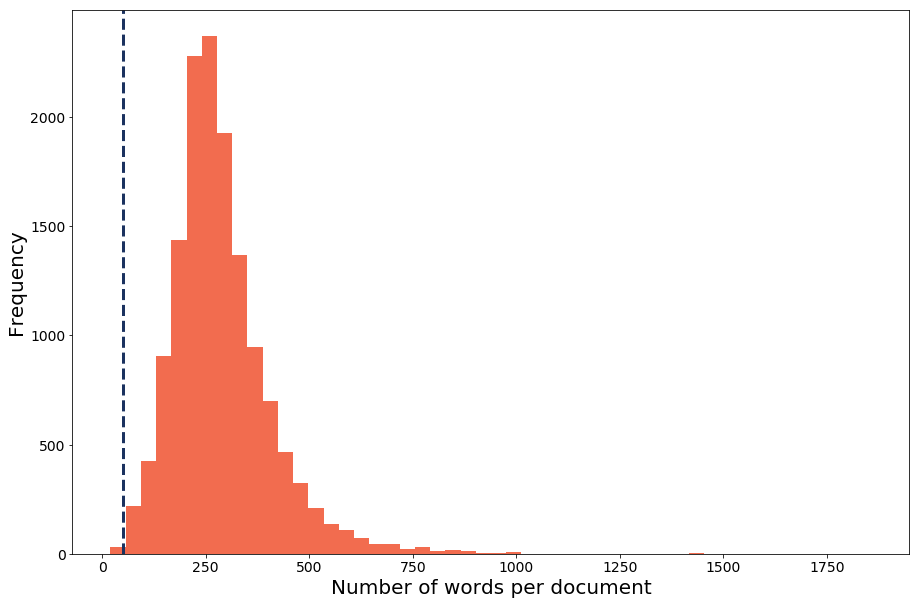

In [23]:
lentok = aotable['tokens'].apply(len)

plt.figure(figsize=(15,10))
plt.hist(lentok, 50, color='#f26c4fff')
plt.xlabel('Number of words per document', fontsize=20)
plt.xticks(fontsize=14)
plt.ylabel('Frequency', fontsize=20)
plt.yticks(fontsize=14)
plt.axvline(50, linestyle='--', linewidth=3, color='#1b325fff')
plt.savefig('fig/SUP_doclength.jpg', format='jpg', dpi=300)
plt.show()

In [24]:
# Remove documents with less than 50 words in their corpora

aotable = aotable[aotable['tokens'].apply(len) > 50].reset_index(drop=True)

In [25]:
%%time

# Convert to named tuples

aodocs = namedtuple('aodocs', 'words tags')

allao = []

for index, row in aotable.iterrows():    
    '''
    Tags must be specified as lists (length 1)
    otherwise the model assumes each *character* is a separate tag
    '''
    plname = [str(row['id'])]     
    word_tokens = row['tokens']

    allao.append(TaggedDocument(words = word_tokens, tags = plname))

CPU times: user 1 s, sys: 14.9 ms, total: 1.02 s
Wall time: 1.02 s


In [26]:
# Examine input data
print(str(len(allao))+' documents')
print(allao[0])

14090 documents
TaggedDocument(['an', 'australian', 'lake', 'whose', 'pink', 'hue', 'defies', 'scientific', 'explanation', 'from', 'a', 'distance', 'lake', 'hillier', 'of', 'australia', 'recherche', 'archipelago', 'looks', 'like', 'a', 'swath', 'of', 'solid', 'bubble', 'gum', 'pink', 'draw', 'closer', 'and', 'the', 'color', 'takes', 'on', 'a', 'more', 'watery', 'translucent', 'quality', 'but', 'remains', 'unmistakably', 'pink', 'whereas', 'the', 'causes', 'behind', 'the', 'unusual', 'coloring', 'of', 'other', 'pink', 'lakes', 'such', 'as', 'the', 'nearby', 'pink', 'lake', 'and', 'senegal', 'lake', 'retba', 'have', 'been', 'definitively', 'confirmed', 'the', 'reason', 'for', 'lake', 'hillier', 'color', 'remains', 'a', 'mystery', 'theories', 'abound', 'of', 'course', 'some', 'speculate', 'that', 'lake', 'hillier', 'color', 'like', 'that', 'of', 'the', 'other', 'lakes', 'is', 'the', 'result', 'of', 'high', 'salinity', 'combined', 'with', 'the', 'presence', 'of', 'a', 'salt', 'loving', 'al

## Build and train the model

In [27]:
# Model parameters
initalpha = 0.05
genstorun = 50
alphastep = initalpha*0.9/genstorun

# Build the model
model = Doc2Vec(dm=0, dbow_words=1,
                vector_size=150, window=8, min_count=2, 
                epochs=50, alpha=initalpha, min_alpha=initalpha, workers=numcores)

print("%s : building vocabulary and initiating model." % model)
%time model.build_vocab(allao)

Doc2Vec(dbow+w,d150,n5,w8,mc2,s0.001,t4) : building vocabulary and initiating model.
CPU times: user 1.89 s, sys: 18.2 ms, total: 1.91 s
Wall time: 1.92 s


In [28]:
# check that model has all the data and that documents have unique tags
print("Description embeddings: %s" % len(model.docvecs))
print("Word embeddings: %s" % len(model.wv.vocab))
print("docvecs count: %s" % model.docvecs.count)
print(len(model.docvecs.vectors_docs))
print(model.corpus_count)

Description embeddings: 14090
Word embeddings: 52210
docvecs count: 14090
14090
14090


In [29]:
%%time
# Train the model 

aoshuf = allao[:]  

'''
To ensure each document is trained an approximately equal number of times,
I will shuffle the documents going into training on each iteration.
'''
for epoch in range(genstorun):   
    shuffle(aoshuf)
    model.train(aoshuf, total_examples=model.corpus_count, epochs=1)
    model.alpha -= alphastep
    model.min_alpha = model.alpha

CPU times: user 45min 30s, sys: 7.01 s, total: 45min 38s
Wall time: 12min 12s


## Explore and engineer features

In [30]:
'''
compute "weirdness" score: mean distance from document to all other documents
the higher the value, the more different that entry is
'''

weirdness = []
for i in aotable['id']:
    mostsimj = model.docvecs.most_similar(str(i), topn=model.docvecs.count)
    cosj =[]
    for j in  mostsimj:
        cosj.append(j[1])
    weirdness.append((i, np.mean(cosj)))

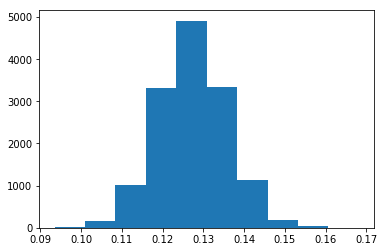

In [31]:
weird = pd.DataFrame(weirdness)
weird.columns = ["id", "weirdness"]

plt.hist(weird['weirdness'])
plt.show()

In [32]:
# pre-sort array
weirdsort =  sorted(weird['weirdness'])

'''
calculate percentiles
since greater mean cosine similarity means greater similarity to all documents,
weirdness should be the inverse of that, so higher values = more isolated
'''

weird['weirdpct'] = weird['weirdness'].apply(lambda x: 100 - round(percentileofscore(weirdsort, x),2))

In [33]:
# merge weirdness score with main table
aotable = pd.merge(aotable, weird, on='id', how='left')

aotable.head(3)

,id,title,subtitle,city,country,location,url,physical_status,lat,lng,keywords,description,imgurl,subdesc,normsubdesc,tokens,weirdness,weirdpct
0,5561,Lake Hillier,An Australian lake whose pink hue defies scien...,,Australia,Australia,https://www.atlasobscura.com/places/lake-hillier,,-34.094179,123.203276,"wonders of salt,natural wonders,watery wonders","From a distance, Lake Hillier of Australia’s R...",https://assets.atlasobscura.com/media/W1siZiIs...,An Australian lake whose pink hue defies scien...,an australian lake whose pink hue defies scien...,"[an, australian, lake, whose, pink, hue, defie...",0.132377,26.78
1,4290,Gippsland Lakes Bioluminescence,Australian Lake set aglow by Noctiluca Scintil...,Raymond Island,Australia,"Raymond Island, Australia",https://www.atlasobscura.com/places/lake-gipps...,,-37.922431,147.791342,"watery wonders,bioluminescence","The conditions were rare, and they were perfec...",https://assets.atlasobscura.com/media/W1siZiIs...,Australian Lake set aglow by Noctiluca Scintil...,australian lake set aglow by noctiluca scintil...,"[australian, lake, set, aglow, by, noctiluca, ...",0.142318,4.00
2,596,The Haunted Bookshop,"Occult books, Tarot, Oddities.",Melbourne,Australia,"Melbourne, Australia",https://www.atlasobscura.com/places/haunted-bo...,,-37.815472,144.961689,"repositories of knowledge,occult,bookstores",The creepy Haunted Bookshop in Melbourne is lo...,https://assets.atlasobscura.com/media/W1siZiIs...,"Occult books, Tarot, Oddities.The creepy Haunt...","occult books , tarot , oddities the creepy h...","[occult, books, tarot, oddities, the, creepy, ...",0.122837,70.29


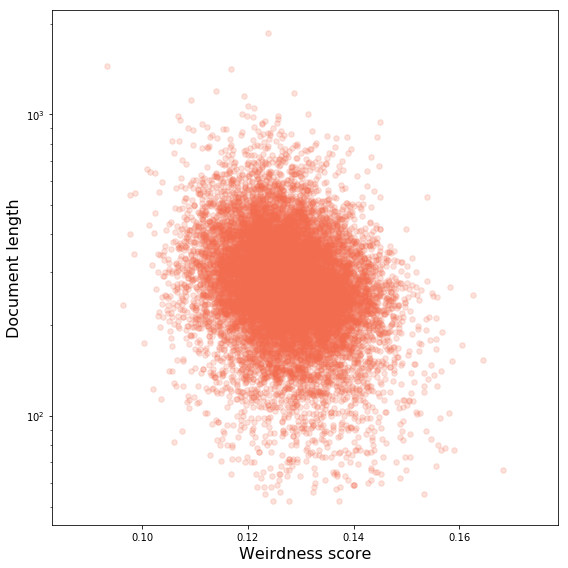

In [35]:
# Is weirdness just capturing length of text? (see figures made from each value)
doclengths = aotable['tokens'].apply(len)

plt.figure(figsize=(8,8))
plt.scatter(aotable['weirdness'], doclengths, color='#f26c4fff', alpha=0.2, s=30)
plt.yscale('log')
plt.ylabel('Document length', fontsize=16)
plt.xlabel('Weirdness score', fontsize=16)
# plt.axhline(50, linestyle='--', linewidth=3, color='#1b325fff')
plt.tight_layout()
plt.savefig('fig/SUP_weirddist_150b_50gen.jpg', format='jpg', dpi=300)
plt.show()

## Do close documents seem similar?

In [36]:
doc_id = str(random.choice(aotable['id']))
similars = model.docvecs.most_similar(doc_id, topn = model.docvecs.count)

print(doc_id + " " + aotable[aotable['id'] == int(doc_id)]['title'].values[0])
print('keywords: ' + aotable[aotable['id'] == int(doc_id)]['keywords'].values[0])
#print('description: ' + aotable[aotable['id'] == int(doc_id)]['description'].values[0])

print("\n")

print("most similar:") 
print(similars[0][0] + " " + aotable[aotable['id'] == int(similars[0][0])]['title'].values[0])
print('keywords: ' + aotable[aotable['id'] == int(similars[0][0])]['keywords'].values[0])
#print('description: ' + aotable[aotable['id'] == int(similars[0][0])]['description'].values[0])

print("\n")

print("Least similar:") 
print(similars[-1][0] + " " + aotable[aotable['id'] == int(similars[-1][0])]['title'].values[0])
print('keywords: ' + aotable[aotable['id'] == int(similars[-1][0])]['keywords'].values[0])
#print('description: ' + aotable[aotable['id'] == int(similars[-1][0])]['description'].values[0])

27700 Roman Wharf Timber
keywords: ruins,bridges,roman,plaques,ruins (internal),bridges (internal),roman (internal),plaques (internal)


most similar:
27278 Uppland Runic Inscription 53
keywords: archaeology,ancient,history,pictograms,vikings,language


Least similar:
2268 Graceland Cemetery
keywords: tombs,graveyards,cemeteries,catacombs, crypts, & cemeteries


In [37]:
model.wv.most_similar('toy')

[('toys', 0.556920051574707),
 ('todmorden', 0.5308510065078735),
 ('juguete', 0.48672518134117126),
 ('vintage', 0.47662168741226196),
 ('holsters', 0.47208383679389954),
 ('squarepants', 0.4654431641101837),
 ('dyersville', 0.4517592489719391),
 ('rideable', 0.4504704177379608),
 ('antique', 0.4406795799732208),
 ('collectibles', 0.43548497557640076)]

In [1]:
tm_infervec = model.infer_vector(['outdoor', 'sculpture'], 
                                 steps=200, alpha=0.025, min_alpha=0.001)

tm_mostsim = model.docvecs.most_similar(positive=[tm_infervec], topn=8)

tm_samp = [x[0] for x in tm_mostsim]
tm_vecas = [x[1] for x in tm_mostsim]

print(tm_vecas)
aotable[aotable['id'].isin(tm_samp)]


NameError: name 'model' is not defined

In [39]:
tm_infervec = model.infer_vector(['toys'], 
                                 steps=200, alpha=0.025, min_alpha=0.001)

mostsimtest = model.docvecs.most_similar(positive=[tm_infervec], topn=8)

samp = [x[0] for x in mostsimtest]
vecas = [x[1] for x in mostsimtest]

print(vecas)
aotable[aotable['id'].isin(samp)]

[0.4868084192276001, 0.4709842801094055, 0.4664589464664459, 0.46481946110725403, 0.4559105634689331, 0.4539436101913452, 0.4539351165294647, 0.45389100909233093]


,id,title,subtitle,city,country,location,url,physical_status,lat,lng,keywords,description,imgurl,subdesc,normsubdesc,tokens,weirdness,weirdpct
1442,15851,Nuremberg Toy Museum,This historic toy museum brings a little whims...,Nuremberg,Germany,"Nuremberg, Germany",https://www.atlasobscura.com/places/nuremberg-...,,49.454627,11.074437,"toy museums,toys",While it is probably true that Nuremberg is mo...,https://assets.atlasobscura.com/media/W1siZiIs...,This historic toy museum brings a little whims...,this historic toy museum brings a little whims...,"[this, historic, toy, museum, brings, a, littl...",0.129963,36.98
1999,9157,Ettore Guatelli Museum,A rambling museum which honors the beauty in e...,Gaiano,Italy,"Gaiano, Italy",https://www.atlasobscura.com/places/ettore-gua...,,44.724528,10.174832,"museums,collections",There is no tool too simple nor artifact too m...,https://assets.atlasobscura.com/media/W1siZiIs...,A rambling museum which honors the beauty in e...,a rambling museum which honors the beauty in e...,"[a, rambling, museum, which, honors, the, beau...",0.124056,64.84
2308,19145,Tin Toy Museum Kitahara Collection,More tin toys than you can shake a clapping mo...,Yokohama,Japan,"Yokohama, Japan",https://www.atlasobscura.com/places/toys-club-...,,35.437665,139.653121,"toys,toy museums,museums and collections,museu...",A random walk through the narrow residential s...,https://assets.atlasobscura.com/media/W1siZiIs...,More tin toys than you can shake a clapping mo...,more tin toys than you can shake a clapping mo...,"[more, tin, toys, than, you, can, shake, a, cl...",0.130038,36.67
6482,8366,Muzeum Zabawek (Toy Museum),The largest toy museum in Poland showcases Eur...,Karpacz,Poland,"Karpacz, Poland",https://www.atlasobscura.com/places/muzeum-zab...,,50.782978,15.761395,"museums,toys,unique collections",This two-story toy museum on the Czech-Polish ...,https://assets.atlasobscura.com/media/W1siZiIs...,The largest toy museum in Poland showcases Eur...,the largest toy museum in poland showcases eur...,"[the, largest, toy, museum, in, poland, showca...",0.137858,10.51
7223,2658,Pegasus Small World Toy Museum,Museum featuring strange and enchanting toys o...,Aeugst am Albis,Switzerland,"Aeugst am Albis, Switzerland",https://www.atlasobscura.com/places/pegasus-sm...,,47.284205,8.487077,"museums and collections,toys,dolls,unique coll...","Billed as an “enchanted world of miniatures,” ...",https://assets.atlasobscura.com/media/W1siZiIs...,Museum featuring strange and enchanting toys o...,museum featuring strange and enchanting toys o...,"[museum, featuring, strange, and, enchanting, ...",0.134844,18.53
8859,2768,Flutter,Delightful disarray of found objects and clutter.,Portland,United States,"Portland, Oregon",https://www.atlasobscura.com/places/flutter,,45.551589,-122.675509,"unique collections,commercial curiosities,purv...","Nobody, it seems, can resist the charms of thi...",https://assets.atlasobscura.com/media/W1siZiIs...,Delightful disarray of found objects and clutt...,delightful disarray of found objects and clutt...,"[delightful, disarray, of, found, objects, and...",0.108634,98.73
11991,21417,Little Nadine Earles Doll House Grave,Inside this small brick bungalow is a collecti...,Lanett,United States,"Lanett, Alabama",https://www.atlasobscura.com/places/little-nad...,,32.870040,-85.202659,"gravestones,cemeteries,architectural oddities,...",Nadine Earles was not yet four years old when ...,https://assets.atlasobscura.com/media/W1siZiIs...,Inside this small brick bungalow is a collecti...,inside this small brick bungalow is a collecti...,"[inside, this, small, brick, bungalow, is, a, ...",0.139065,8.13
12603,20869,National Farm Toy Museum,The farm toy capital of the world hosts a muse...,Dyersville,United States,"Dyersville, Iowa",https://www.atlasobscura.com/places/national-f...,,42.470973,-91.111035,"collections,farms,toys,museums and collections",A toy museum may not seem like the most obviou...,https://assets.atlasobsc

# Supplementary material

## Exploring keywords

In [40]:
megastring = ','.join(list(aotable['keywords']))

keys = megastring.split(",")

keystable = pd.DataFrame(Counter(keys), index=['count']).T.reset_index().rename(columns={'index':'keyword'})

keystable = keystable.sort_values(by='count', ascending=False).reset_index(drop=True).drop(0)

keystable.head(5)

,keyword,count
1,museums,1383
2,museums and collections,1200
3,art,914
4,history,912
5,architecture,799


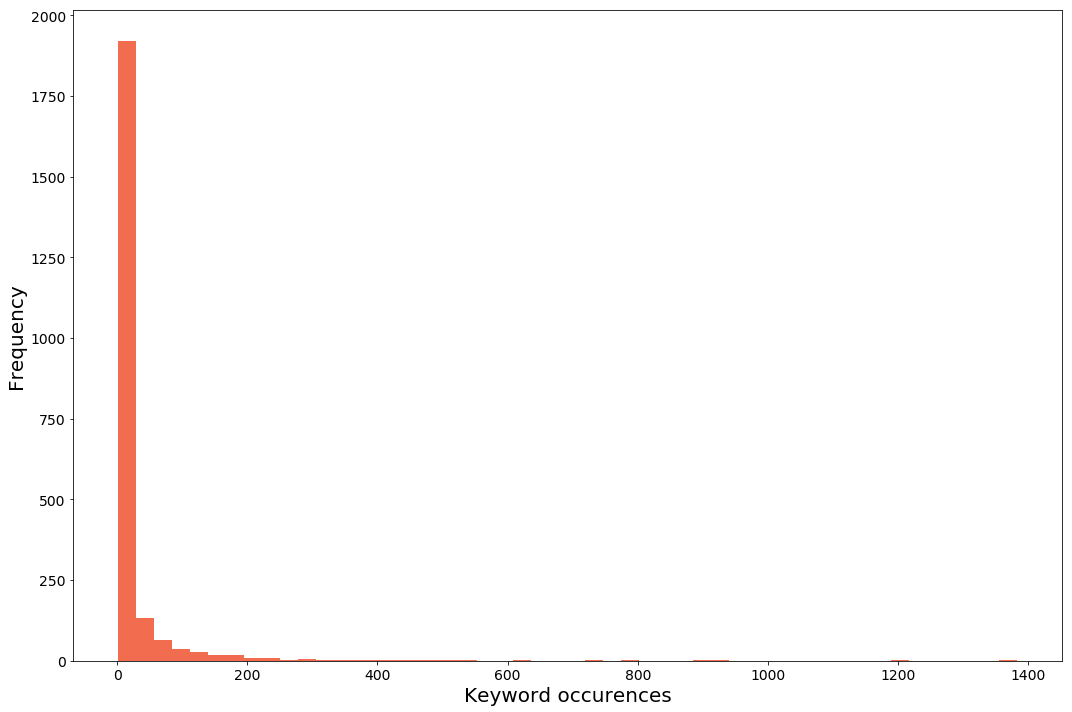

In [41]:
plt.figure(figsize=(15,10))
plt.hist(keystable['count'], bins=50, color='#f26c4fff')
plt.xlabel('Keyword occurences', fontsize=20)
plt.xticks(fontsize=14)
plt.ylabel('Frequency', fontsize=20)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('fig/SUP_keywordfreq.jpg', format='jpg', dpi=300)
plt.show()

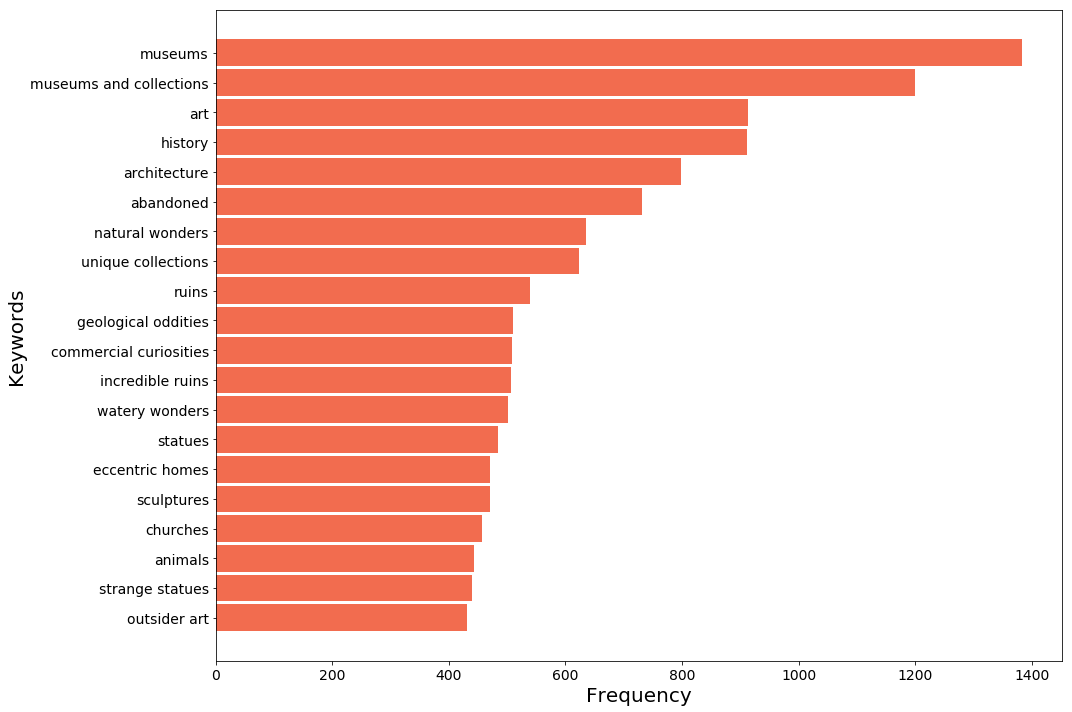

In [42]:
plt.figure(figsize=(15,10))
plt.barh(range(20), keystable['count'].head(20), height=0.9, color='#f26c4fff')
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=14)
plt.ylabel('Keywords', fontsize=20)
plt.yticks(range(20), keystable['keyword'].head(20), fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('fig/SUP_keywordsTop20.jpg', format='jpg', dpi=300)
plt.show()

## Exploring the model: cosine similarity distribution

In [43]:
#for each article, find the cosine similarity to each other article
cossim = []
for i in range(model.corpus_count):
    for j in range(i+1, model.corpus_count):
        cossim.append(model.docvecs.similarity(i,j))

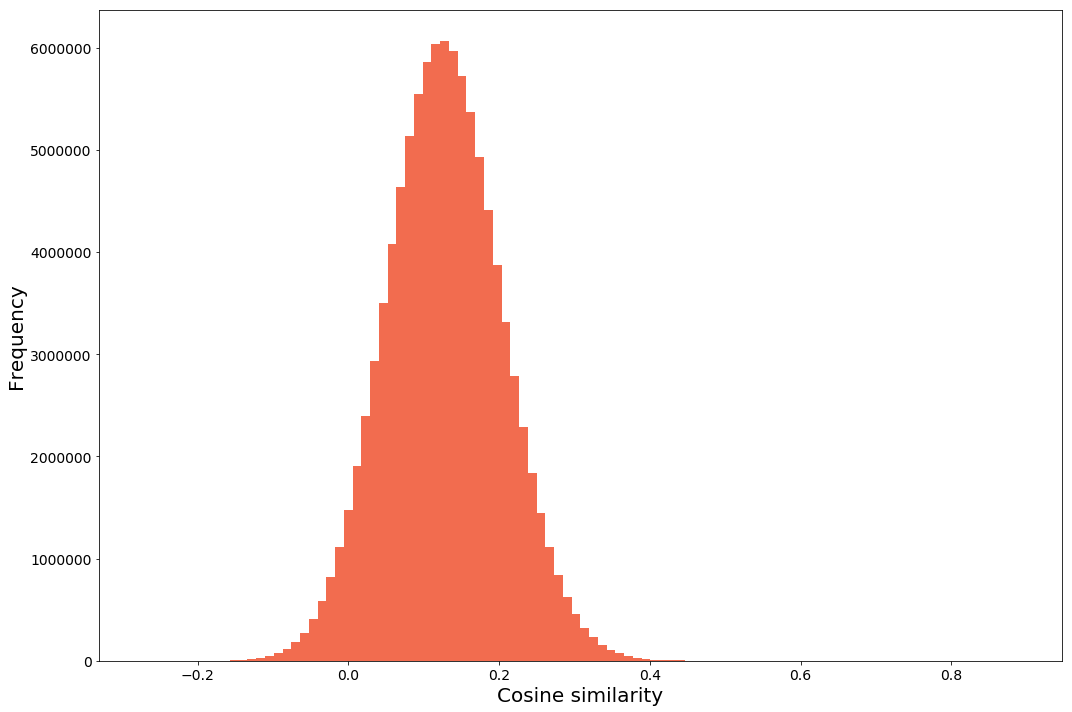

In [46]:
plt.figure(figsize=(15,10))
plt.hist(cossim, bins=100, color='#f26c4fff')
plt.xlabel('Cosine similarity', fontsize=20)
plt.xticks(fontsize=14)
plt.ylabel('Frequency', fontsize=20)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('fig/SUP_CosSimDist.jpg', format='jpg', dpi=300)
plt.show()

## Exploring the model: tag clustering

## saving results

In [47]:
# SAVING OUTPUT
with open('data/AOmasterdata-nodup-week4-clean', 'wb') as outfile:
     pickle.dump(aotable, outfile)

with open('data/taggeddocs-week4-clean', 'wb') as outfile:
     pickle.dump(allao, outfile)

model.save('data/model-week4-clean')